In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy as sc

# OS imports
from os.path import join as ospj
from tqdm import tqdm
from utils import *
from config import Config

# Load in the data
datapath, prodatapath, metapath, figpath = Config.deal(['datapath','prodatapath','metapath','figpath'])

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [4]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = Config.deal()

## Stimulation Interpolation

### Loading seizures

In [5]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP235' # setting example patient

In [6]:
# Loading data from bids
inter,fs = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter = inter[chn_labels]
electrode_localizations = pd.read_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
electrode_regions = pd.read_pickle(ospj(prodatapath,pt,'electrode_localizations_dkt.pkl'))
neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter = inter.loc[:,neural_channels]

FileNotFoundError: Root directory does not exist: "/Users/wojemann/Documents/CNT/stim-seizures-manuscript/code/BIDS"

In [ ]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <= -1:
        continue
    
    # Load in seizure and metadata for BIDS path
    stim_seizure,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    
    # Filter out bad channels from interictal clip
    stim_seizure = stim_seizure[neural_channels]
    break

(<Figure size 10233.3x1560 with 1 Axes>, <Axes: xlabel='Time (s)'>)

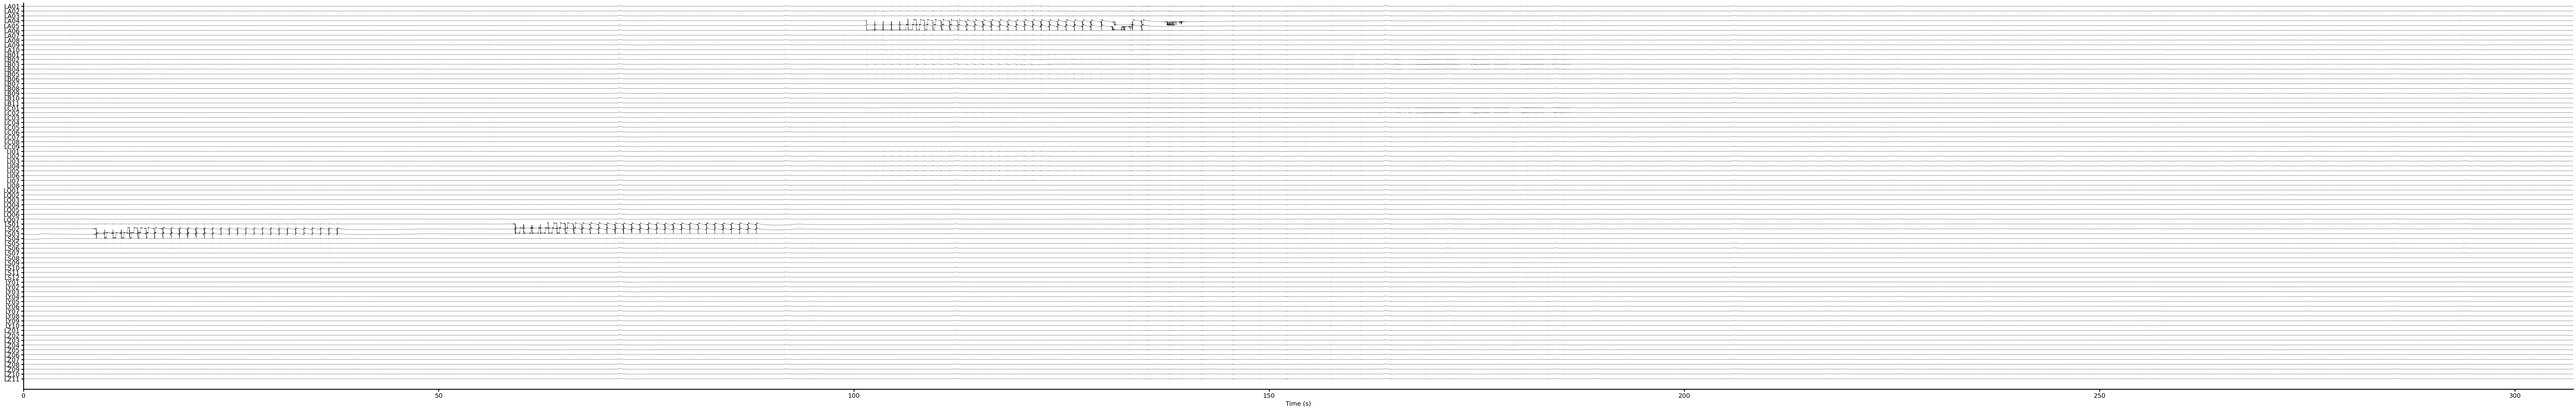

In [ ]:
plot_iEEG_data(stim_seizure,fs=fs_raw)

### Operationalizing insertion process

In [ ]:
'''
for pt in patient_list:
    get interictal data
    get baseline stds
    find stimulation artifacts in stim channels
    get spontaneous seizure
    insert artifacts into spontaneous seizure
    extract signal around inserted signals
    extract signal around original signal
    correlate the two in time
    append correlation
    perform fft
    correlate the two in freq
    append correlation
    perform barn door interpolation
    extract signal around barn door
    correlate the two in time
    append correlation
    perform fft
    correlate the two in freq
    append correlation
'''
pt_idxs = {'HUP235': 9,
           'HUP238': 1,
           'HUP224': 2,
           'HUP230': 18,
           'HUP246': 1,
           'HUP249': 1,
           'HUP247': 3,
           'HUP225': 1}

In [ ]:
def insert_artifact(spont_sz,stim_raw,peak_idxs,fs=1024,pre_win=15e-3,post_win=60e-3):
    '''
    spont_sz: dataframe
    stim_sz: dataframe
    stim_ch_idx: index into the channels of the stim_sz for the stimulating channel
    fs: sampling frequency (Hz)
    pre_win: window prior to first detected stim. artifact to insert (s)
    post_win: window after first detected stim. artifact to insert (s)
    '''

    #Ensure that the stimulation seizuire is not longer than spontaneous
    stim_sz = stim_raw.copy()
    if len(spont_sz) < len(stim_sz):
      endpoint = len(spont_sz)
      stim_sz = stim_sz.iloc[:endpoint,:]

    pre_win_idx = int(pre_win * fs)
    post_win_idx = int(post_win * fs)

    art_sz = spont_sz.copy()
    for ch in range(stim_sz.shape[1]): # loop through each channel
        for pk in peak_idxs: # loop through each stim
            # Checking to make srue pre_idx doesn't overlap with start of seizure

            if pk < pre_win_idx:
              temp_pre_idx = pk
            else:
              temp_pre_idx = pk - pre_win_idx

            # Check to make sure post_idx doesn't extend past seizure
            if post_win_idx+pk > len(stim_sz):
              temp_post_idx = len(stim_sz)-pk
            else:
              temp_post_idx = post_win_idx + pk

            stim_sample = stim_sz.iloc[temp_pre_idx:temp_post_idx,ch]
            offset_v = stim_sz.iloc[temp_pre_idx,ch] - spont_sz.iloc[temp_pre_idx-1,ch]

            # Offset so start of artifact aligns with end of spontaenous
            stim_sample -= offset_v
            art_sz.iloc[temp_pre_idx:temp_post_idx,ch] = stim_sample
    return art_sz

In [ ]:
def get_inter_info(pt,datapath,prodatapath):
    inter,_ = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
    # Pruning channels
    chn_labels = remove_scalp_electrodes(inter.columns)
    inter = inter[chn_labels]
    if 'CHOP' in pt:
        trode_path = ospj(prodatapath,pt,'electrode_localizations_CHOPM.pkl')
    else:
        trode_path = ospj(prodatapath,pt,'electrode_localizations_atropos.pkl')
    electrode_localizations = pd.read_pickle(trode_path)
    neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
    inter = inter.loc[:,neural_channels]
    return inter.std().to_numpy(),neural_channels

def get_sz_info(pt,row_idx,datapath,neural_channels,seizure_times):
    for i,(_,sz_row) in enumerate(seizure_times.iterrows()):
        if i != row_idx:
            continue
        # Load in seizure and metadata for BIDS path
        spont_seizure,fs_raw, _, _, _, _ = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
        # Filter out bad channels from interictal clip
        spont_seizure = spont_seizure[neural_channels]
        # seizure,fs = preprocess_for_detection(seizure,fs_raw,pre_mask=mask)
        break
    return spont_seizure,fs_raw,sz_row

def get_stim_info(sz_row,stim_seizure):
    stim_ch_mask = np.zeros((len(stim_seizure.columns),),dtype=bool)
    for ch in sz_row.stim_channels.split('-'):
        # print(clean_labels([ch],pt))
        ch = clean_labels([ch],pt)[0]
        stim_ch_mask += np.array([ch == c for c in stim_seizure.columns])
    stim_ch = stim_seizure.loc[:,stim_ch_mask].to_numpy()[:,1]
    return stim_ch,stim_ch_mask

def stim_detect(data,threshold,fs):
    pks,_ = sc.signal.find_peaks(np.abs(np.diff(data)),height=threshold,distance=fs/2)
    return pks

def artifact_detect(data,fs,thresholds):
    pk_kwargs = {}
    for i_c,col in enumerate(data.columns):
        pk_kwargs[col] = {'height':thresholds[i_c], 'distance':fs/2}
    peaks = data.apply(lambda x: len(sc.signal.find_peaks(x.diff().abs(), **pk_kwargs[x.name])[0]))
    return peaks.to_numpy() > 0

def chunk_corr(sz_1,sz_2,pk_idxs,stim_ch_mask,fs,win=0.05,freq=False, art_chs = None):
    if art_chs is None:
        art_chs = np.ones(sz_1.shape[1],dtype=bool)
    sz_1,sz_2,art_chs = sz_1.loc[:,~stim_ch_mask],sz_2.loc[:,~stim_ch_mask],art_chs[~stim_ch_mask]
    ch_idxs = np.where(art_chs)[0]
    win_idx = np.floor(win*fs)
    effect_list = []
    for idx in pk_idxs:
        for ch in ch_idxs:
            sidx = int(idx-win_idx)
            eidx = int(idx+win_idx)
            clip1 = sz_1.iloc[sidx:eidx,ch]
            clip2 = sz_2.iloc[sidx:eidx,ch]
            if freq:
                _,clip1 = sig.welch(clip1,fs)
                _,clip2 = sig.welch(clip2,fs)
            r2 = np.corrcoef(clip1,clip2)[0][1]**2
            effect_list.append(r2)
    return effect_list

def barndoor(sz,pk_idxs,fs,pre=50e-3,post=100e-3,plot = False):
    data = sz.copy()
    pre_idx = np.floor(pre*fs).astype(int)
    post_idx = np.floor(post*fs).astype(int)
    win_idx = pre_idx + post_idx
    taper = np.linspace(0,1,win_idx)
    for idx in pk_idxs:
        sidx = int(idx-pre_idx)
        eidx = int(idx+post_idx)
        pre_data = data.iloc[sidx-win_idx:sidx,:].to_numpy()
        post_data = data.iloc[eidx:eidx+win_idx,:].to_numpy()
        data.iloc[sidx:eidx,:] = np.flip(pre_data,0) * np.flip(taper).reshape(-1,1) + np.flip(post_data,0) * taper.reshape(-1,1)
        if plot:
            shifted_xticks = np.linspace(-(pre+win_idx/fs),(post+win_idx/fs),win_idx*3)
            linear_xticks = np.linspace(0,pre+post,win_idx)
            _,axs = plt.subplots(4,1,figsize=(5,10))
            axs[0].plot(shifted_xticks,sz.iloc[sidx-win_idx:eidx+win_idx,8],label='Original',color='black')
            axs[0].axvline(-pre)
            axs[0].axvline(post)
            axs[0].legend()
            # axs[0].set_ylabel('Amplitude (mV)')
            sns.despine()
            axs[1].plot(linear_xticks,np.flip(pre_data[:,8],0),label='Pre Data')
            axs[1].plot(linear_xticks,np.flip(post_data[:,8],0),label='Post Data')
            axs[1].legend()
            # axs[1].set_ylabel('Amplitude (mV)')
            sns.despine()
            
            axs[2].plot(linear_xticks,np.flip(taper),label='Pre Taper')
            axs[2].plot(linear_xticks,taper,label='Post Taper')
            axs[2].legend()
            # axs[2].set_ylabel('Amplitude (mV)')
            sns.despine()
            axs[3].plot(shifted_xticks,data.iloc[sidx-win_idx:eidx+win_idx,8],label='Repaired',color='black')
            axs[3].axvline(-pre)
            axs[3].axvline(post)
            sns.despine()
            axs[3].legend()
            axs[3].set_xlabel('Time (ms)')
            # axs[3].set_ylabel('Amplitude (mV)')
            plt.savefig(ospj(figpath,'figure_S1_A.pdf'))
            plt.show()

            fig = plt.figure(figsize=(5,4))
            plt.plot(shifted_xticks,sz.iloc[sidx-win_idx:eidx+win_idx,8],label='Artifact',color='red')
            plt.plot(shifted_xticks,data.iloc[sidx-win_idx:eidx+win_idx,8],label='Repaired',color='blue')
            plt.axvline(-pre,color='k',label='_nolegend_')
            plt.axvline(post,color='k',label='_nolegend_')
            plt.legend()
            plt.xlabel('Time (ms)')
            plt.ylabel('Amplitude (mV)')
            sns.despine()
            plt.show()
            fig.savefig(ospj(figpath,'figure_S1_B.pdf'),bbox_inches='tight')
            plot=False

    return data

In [ ]:
time_injected_effects = []
time_repaired_effects = []
freq_injected_effects = []
freq_repaired_effects = []
for pt in pt_idxs.keys():
    baseline_stds,neural_channels = get_inter_info(pt,datapath,prodatapath)
    seizure_times = seizures_df[seizures_df.Patient == pt]
    qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
    stim_sz,fs_raw,sz_row = get_sz_info(pt,0,datapath,neural_channels,seizure_times)
    spont_sz,_,_ = get_sz_info(pt,pt_idxs[pt],datapath,neural_channels,seizure_times)
    stim_ch,stim_ch_mask = get_stim_info(sz_row,stim_sz)
    threshold = baseline_stds[stim_ch_mask][1]*100
    pk_idxs = stim_detect(stim_ch,threshold,fs_raw)
    art_sz = insert_artifact(spont_sz,stim_sz,pk_idxs,fs=fs_raw)
    thresholds = baseline_stds*3
    art_chs = artifact_detect(art_sz.iloc[(pk_idxs[-1]-fs):(pk_idxs[-1]+fs),:],fs,thresholds)
   
    inj_effects = chunk_corr(stim_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,art_chs=art_chs)
    time_injected_effects.append(np.nanmean(inj_effects))
    inj_effects = chunk_corr(stim_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,freq=True,art_chs=art_chs)
    freq_injected_effects.append(np.nanmean(inj_effects))

    barn_data = barndoor(art_sz,pk_idxs,fs_raw)
    inj_effects = chunk_corr(art_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,art_chs=art_chs)
    time_repaired_effects.append(np.nanmean(inj_effects))
    inj_effects = chunk_corr(art_sz,spont_sz,pk_idxs,stim_ch_mask,fs_raw,freq=True,art_chs=art_chs)
    freq_repaired_effects.append(np.nanmean(inj_effects))
    

WilcoxonResult(statistic=1.0, pvalue=0.015625)

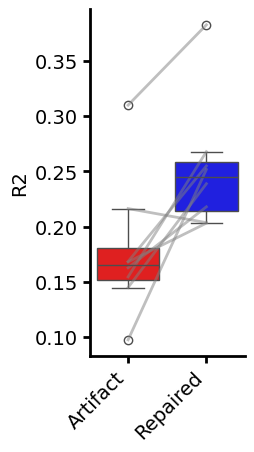

In [ ]:
plt.figure(figsize=(2,4.5))
violin_parts = sns.boxplot((time_injected_effects,time_repaired_effects),palette=['red','blue'])#,showextrema=False,quantiles=[[.25,.5,.75],[.25,.5,.75]])
for i in range(len(time_injected_effects)):
    plt.plot([0, 1], [time_injected_effects[i], time_repaired_effects[i]], color='gray', alpha=0.5, linewidth=2)
plt.ylabel('R2')
plt.xticks([0,1],["Artifact","Repaired"],rotation=45,ha='right')
sns.despine()
plt.savefig(ospj(figpath,'figure_S1_C.pdf'),bbox_inches='tight')
sc.stats.wilcoxon(time_injected_effects,time_repaired_effects)

WilcoxonResult(statistic=1.0, pvalue=0.015625)

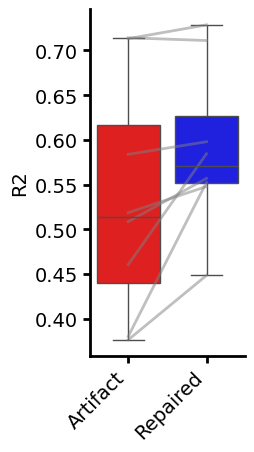

In [ ]:
plt.figure(figsize=(2,4.5))
violin_parts = sns.boxplot((freq_injected_effects,freq_repaired_effects),palette=['red','blue'])#,showextrema=False,quantiles=[[.25,.5,.75],[.25,.5,.75]])
plt.ylabel('R2')
plt.xticks([0,1],["Artifact","Repaired"],rotation=45,ha='right')
sns.despine()
# Add a lineplot to show paired samples
for i in range(len(freq_injected_effects)):
    plt.plot([0, 1], [freq_injected_effects[i], freq_repaired_effects[i]], color='gray', alpha=0.5, linewidth=2)
plt.savefig(ospj(figpath,'figure_S1_D.pdf'),bbox_inches='tight')
sc.stats.wilcoxon(freq_injected_effects,freq_repaired_effects)


### New insertion for all stim

In [ ]:
def stim_detect(data,threshold,fs):
    all_pks = np.zeros_like(data)
    for i, (_, ch) in enumerate(data.items()):
        pks,_ = sc.signal.find_peaks(np.abs(np.diff(ch.to_numpy())),
                                    height=threshold[i],
                                    distance=fs/4*3,
                                    )
        all_pks[pks,i] = 1
    
    pk_idxs,_ = sc.signal.find_peaks(all_pks.sum(axis=1),
                            distance=fs/4*3,
                            )
    stim_chs = all_pks.any(0)
    return pk_idxs,stim_chs

  0%|          | 0/12 [00:00<?, ?it/s]

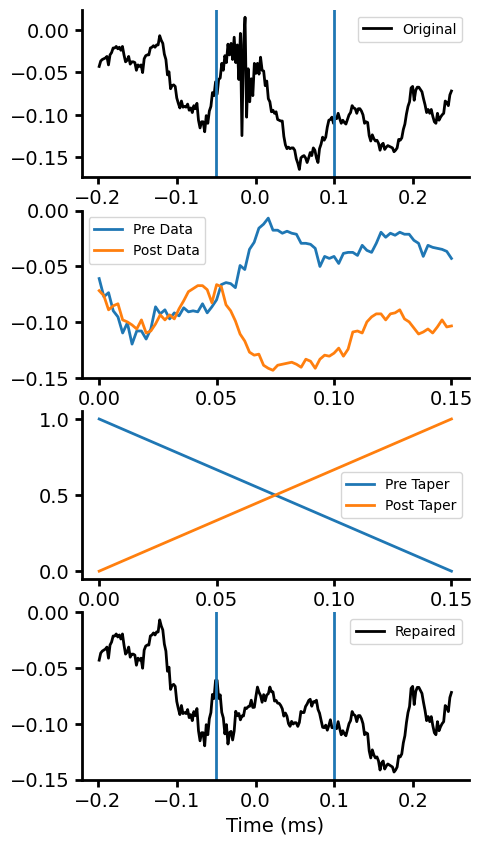

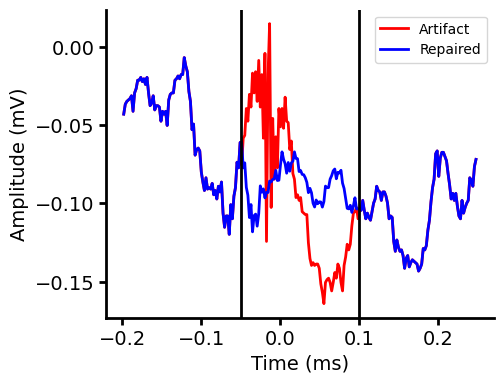

In [ ]:
# This cell generates panels in supplementary figure 1
for pt in ['HUP235']:
    baseline_stds,neural_channels = get_inter_info(pt,datapath,prodatapath)
    seizure_times = seizures_df[seizures_df.Patient == pt]
    qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
    stim_sz,fs_raw,sz_row = get_sz_info(pt,0,datapath,neural_channels,seizure_times)
    stim_ch,stim_ch_mask = get_stim_info(sz_row,stim_sz)    
    pk_idxs,stim_chs = stim_detect(stim_sz,baseline_stds*100,fs_raw)
    
    repaired_data = barndoor(stim_sz,pk_idxs,fs_raw,plot=True)
    break

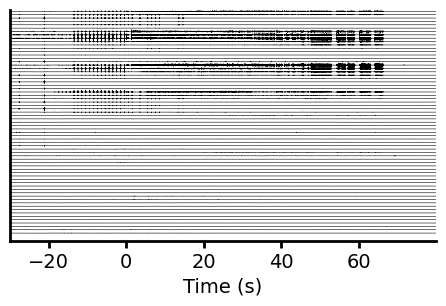

In [ ]:
pre_repaired_data,_ = preprocess_for_detection(repaired_data.loc[:,~stim_ch_mask],fs_raw,
                                                wavenet=False,
                                                pre_mask=mask,
                                                target=fs_raw,
                                                )

plot_time = np.arange(len(pre_repaired_data))/fs_raw
plot_inds = (plot_time > 90) & (plot_time < 200)
plot_iEEG_data(pre_repaired_data.loc[plot_inds,:],fs_raw,fig_size=(4.5*1.2222222222222,3),t_offset=-30)
plt.yticks([])
plt.savefig(ospj(figpath,'figure_1_C.pdf'),bbox_inches='tight')